In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature

# from skimage.util import random_noise

def canny_DoG(img=None, weak_th=None, strong_th=None):
    
    gx = ndi.gaussian_filter(img, sigma=0.5, order=[0,1], output=np.float64, mode='nearest')
    gy = ndi.gaussian_filter(img, sigma=0.5, order=[1,0], output=np.float64, mode='nearest')

    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
        
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th: weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
        
    # getting the dimensions of the input image  
    height, width = img.shape
        
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
                
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
                
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
                
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
                
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
                
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
                
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue

            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0

    # double thresholding step   
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_x, strong_y = np.where(img >= strong_th)
    zeros_x, zeros_y = np.where(img < weak_th)
    
    weak_x, weak_y = np.where((img <= strong_th) & (img >= weak_th))
    
    mag[strong_x, strong_y] = strong
    mag[weak_x, weak_y] = weak

    # hysteresis
    for i_y in range(width):
        for i_x in range(height):
            if (mag[i_x, i_y] == weak):
                try:
                    if ((mag[i_x+1, i_y-1] == strong) or (mag[i_x+1, i_y] == strong) or (mag[i_x+1, i_y+1] == strong)
                        or (mag[i_x, i_y-1] == strong) or (mag[i_x, i_y+1] == strong)
                        or (mag[i_x-1, i_y-1] == strong) or (mag[i_x-1, i_y] == strong) or (mag[i_x-1, i_y+1] == strong)):
                        mag[i_x, i_y] = strong
                    else:
                        mag[i_x, i_y] = 0
                except IndexError as e:
                    pass
        
    # finally returning the magnitude of
    # gradients of edges
    return mag

<Figure size 640x480 with 0 Axes>

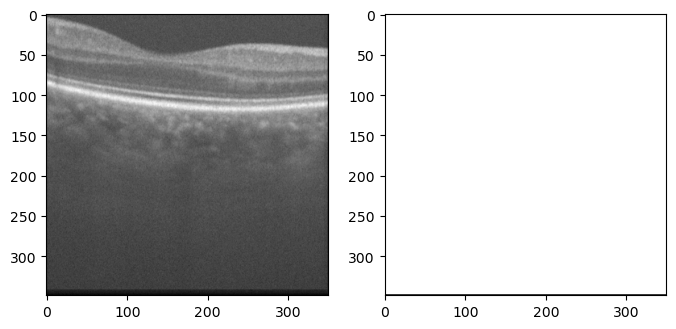

In [56]:
original = cv2.imread('retina2/172.bmp')

# Temporal Averaging
# smooth = cv2.imread('sample_172_201_Nwindow30.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg5_172-176.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg10_172-181.bmp')
temporal = cv2.imread('viz_outputs/retina2_ksize1_tavg15_172-186.bmp', cv2.COLOR_BGR2GRAY)

canny = canny_DoG(img=temporal)
   
# Displaying the input and output image  
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor='white')
ax[0].imshow(temporal, cmap='gray')
ax[1].imshow(canny, cmap='gray')


In [44]:
temporal[348]

array([ 3,  4,  7,  9,  7,  8, 10,  5,  8, 10, 11, 10, 10,  9,  9,  8,  6,
       10, 10, 10,  8,  5,  9, 11,  7,  5,  8,  9, 10,  9,  5, 11,  6,  9,
        9, 10, 10,  9,  6,  8,  8, 10, 10, 10,  7,  9, 10,  8,  8, 11,  8,
        8,  5,  8, 10,  8, 10, 10, 10,  9,  6, 10,  9, 11,  8,  5,  9, 11,
        9,  7,  7,  9,  8,  9,  9, 11,  9, 10, 10,  7,  8,  8,  9, 10,  8,
        7,  8, 10, 12,  9,  8,  9,  8,  8,  9,  8,  8,  8,  9,  9,  9,  9,
       11,  9,  8,  9,  9,  9,  9,  7,  9,  9,  7,  6,  9,  8,  6,  6,  8,
        9, 10, 10, 11,  9, 10,  8,  7, 10, 10,  9,  9,  9,  8,  9,  9, 11,
        8,  8,  9,  9,  9,  6,  8, 10,  9,  9, 10, 10,  8, 10, 10,  7,  9,
        8, 10,  9, 10, 10, 10,  9,  7,  9, 10,  9,  7,  8,  6,  9, 10,  8,
        9,  9,  7,  9,  9, 10, 11,  8,  8, 10, 10, 10, 10, 11,  9,  8, 10,
        9,  9,  9, 10,  9, 10, 11,  8, 10,  9,  8, 11,  9,  8,  9,  9,  9,
        9,  7,  7,  8,  9,  8,  8,  8,  8,  8, 10,  9, 10,  8,  8,  7,  9,
        9, 11, 10, 10,  9

In [173]:
import cv2
import numpy as np

sigma = 0.33

img = cv2.imread('retina2/172.bmp')
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# smooth = cv2.imread('sample_172_201_Nwindow30.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg5_172-176.bmp')
# smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg10_172-181.bmp')
smooth = cv2.imread('viz_outputs/retina2_ksize1_tavg15_172-186.bmp')

log_ir = np.log(smooth+1)
v_min = log_ir.min()
v_max = log_ir.max()
print(v_min, v_max)

smooth = ((log_ir/v_min)*255).astype(np.uint8)
cv2.imwrite('viz_outputs/log.png', smooth)

sobelX = cv2.Sobel(smooth, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(smooth, cv2.CV_64F, 0, 1)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)

# auto canny
v = np.median(smooth)
# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))

# canny = cv2.Canny(smooth, lower, upper, 7)
print(lower, upper)
canny = cv2.Canny(smooth, 110, 300, 3)
canny = np.repeat(np.expand_dims(canny, axis=2), 3, axis=2)
canny = canny * (0.5, 0.5, 1.0)

cv2.imwrite('viz_outputs/blur.png', smooth)
cv2.imwrite('viz_outputs/canny.png', canny)
cv2.imwrite('viz_outputs/sobel.png', sobelCombined)

1.099 5.188
105 210


True

In [10]:
dest = cv2.Laplacian(smooth, cv2.CV_16S, ksize=3)
abs_dest = cv2.convertScaleAbs(dest)
cv2.imwrite('viz_outputs/laplacian.png', abs_dest)

True

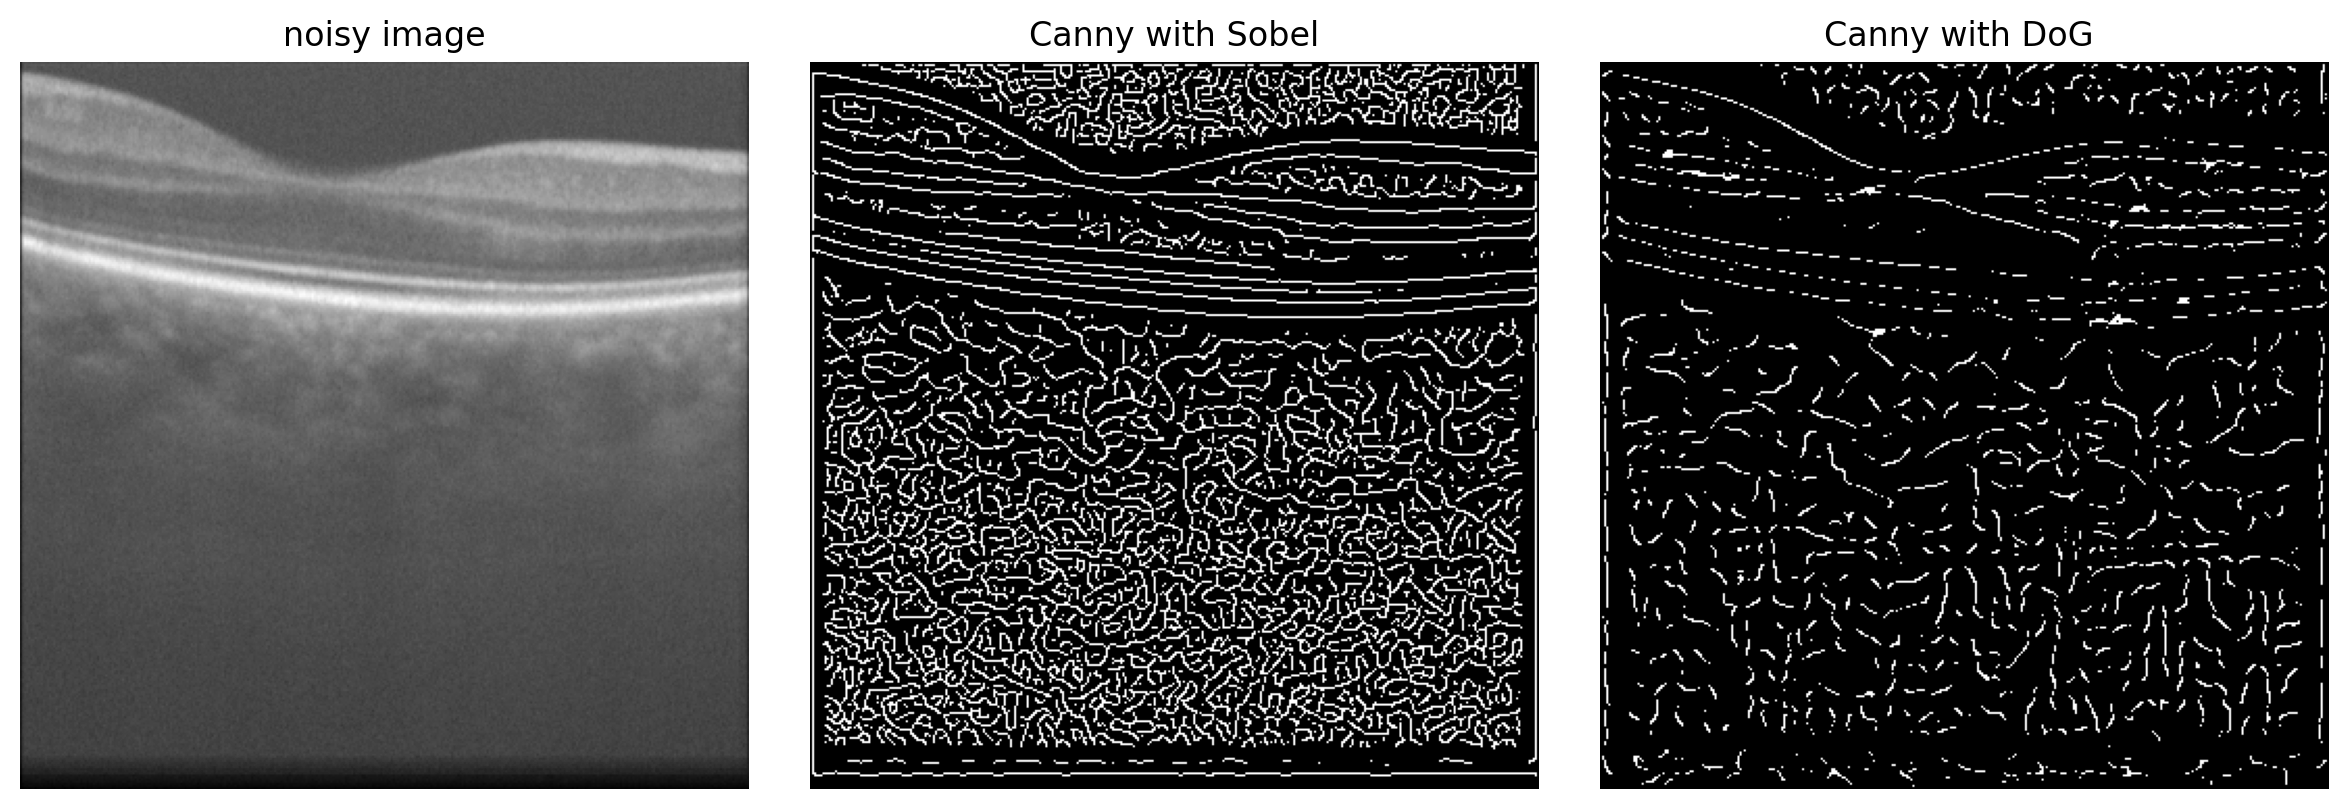

In [15]:
import cv2, importlib
import matplotlib.pyplot as plt
from skimage import feature
import canny_from_scratch2 as custom

importlib.reload(custom)

image = cv2.imread('viz_outputs/retina2_ksize1_tavg30_172-201.bmp', cv2.COLOR_BGR2GRAY)
edges1 = feature.canny(image, sigma=2, low_threshold=0.05, high_threshold=0.2)
edges2 = custom.canny(image, sigma=2, low_threshold=0.05, high_threshold=0.15)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=200)

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image')

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title('Canny with Sobel')

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title('Canny with DoG ')

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()